# Deep learning with PyTorch

Classical ML relies on stats to find the relationship between features and labels. However, a massive growth in data + advanced computing tech has led to new ML techniques that mimic the way the brain processes information instructures called Artificial Neural Nets.

## Creating a Neural Network with PyTorch
PyTorch is a framework for creating ML models, that includes deep neural netwroks (DNNs). In this example, we use PyTorch to create simple neural networks that classify iris flowers.

## Exploring the Iris dataset
we will get the data from sklearn, and also split the data.

In [1]:
import numpy 
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)

print(f'Training Set: {len(X_train)}, Test Set: {len(X_test)}\n')

Training Set: 90, Test Set: 60



The features are the measurements for each iris observation, and the label is a numeric value that indicates the species of iris that the observation represents (versicolor, virginica, or setosa).

In [5]:
import torch 
import torch.nn as nn
import torch.utils.data as td

print(f'Libraries imported. Ready to use Pytorch {torch.__version__}')

Libraries imported. Ready to use Pytorch 1.5.1


## Preparing data for PyTorch
PyTorch makes use of **data loaders** to load training and validation data in batches. We have to take our numpy arrays of our data and:
- wrap them in PyTorch datasets (which will be converted to PyTorch tensor objects)
- create loaders to read batches from those datasets 

In [3]:
# create a dataset and loader for the training data & labels
train_x = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x, train_y)
train_loader = td.DataLoader(
    train_ds,
    batch_size=10,
    shuffle=False,
    num_workers=1
)

# create a dataset and loader for the test data & labels
test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x, test_y)
test_loader= td.DataLoader(
    test_ds,
    batch_size=10,
    shuffle=False,
    num_workers=1
)

print('Ready to load data...')

Ready to load data...


# Define a Neural Network
We will now create a neural network that has 3 fully-connected layers:
- An input layer: receives 4 input values (iris features) & applies a ReLU activation function
- A hidden output layer: receives 10 inputs and applies a ReLU activation function 
- An output layer: uses SoftMax activation function to generate three ouputs (which represent our probabilities for the three species) 

In [6]:
# no of nodes in our hidden layer
hl = 10

# Define the neural net
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x 

# create model instance from the network
model = IrisNet()
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


## Train the model
To train the model, we need to:
- repeatedly feed the training values forward through the network
- use a loss function to calculate the loss
-  use an optimizer to backpropagate weights & bias value adjustments
- validate the model using test data we withheld

We will create a function to train and optimise the model, and a function to test the model. Then, we will call these functions iteratively over 50 epochs, logging the loss & accuracy stats for each epoch.

In [8]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
       


# Specify the loss criteria (CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Specify the optimizer (we'll use a Stochastic Gradient Descent optimizer)
learning_rate = 0.01
learning_momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_momentum)

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1
Training set: Average loss: 1.108103
Validation set: Average loss: 1.093861, Accuracy: 36/60 (60%)

Epoch: 2
Training set: Average loss: 1.097950
Validation set: Average loss: 1.097552, Accuracy: 30/60 (50%)

Epoch: 3
Training set: Average loss: 1.087521
Validation set: Average loss: 1.094759, Accuracy: 16/60 (27%)

Epoch: 4
Training set: Average loss: 1.073799
Validation set: Average loss: 1.080844, Accuracy: 16/60 (27%)

Epoch: 5
Training set: Average loss: 1.052265
Validation set: Average loss: 1.055921, Accuracy: 19/60 (32%)

Epoch: 6
Training set: Average loss: 1.021035
Validation set: Average loss: 1.025868, Accuracy: 25/60 (42%)

Epoch: 7
Training set: Average loss: 0.979525
Validation set: Average loss: 0.986934, Accuracy: 28/60 (47%)

Epoch: 8
Training set: Average loss: 0.931488
Validation set: Average loss: 0.944437, Accuracy: 37/60 (62%)

Epoch: 9
Training set: Average loss: 0.886969
Validation set: Average loss: 0.913891, Accuracy: 37/60 (62%)

Epoch: 10
Training 

### Review Training and Validation Loss
After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:
* The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
* The training loss and validations loss should follow a similar trend, showing that the model is not overfitting to the training data.

Let's plot the loss metrics and see:

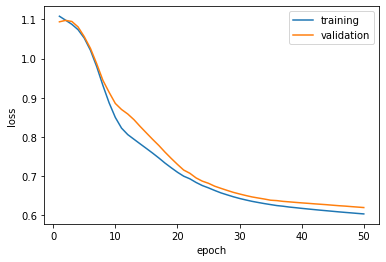

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### View the Learned Weights and Biases
The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:
* Layer 1: There are four input values going to ten output nodes, so there should be 10 x 4 weights and 10 bias values.
* Layer 2: There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
* Layer 3: There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values.

In [10]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[ 0.697539    0.87646794 -0.82624257 -0.6530621 ]
 [-0.04403771  0.37172204  0.5232136   0.40215838]
 [-0.27208817  0.21044147  0.15578943  0.04352093]
 [-0.17074333 -0.3007194   1.3055214   0.55638033]
 [-0.36423394  0.04523045  0.54858595  0.56493485]
 [-0.00956416  0.0649267  -0.36932033  0.47817302]
 [ 0.72705215  0.13414198 -0.5385125  -0.7968503 ]
 [-0.12880874  0.25644374 -0.46099955  0.40774894]
 [ 0.7541426   0.61813    -0.19670154 -0.28108284]
 [-0.24639589 -0.49085963 -0.11169815  0.42909092]]
fc1.bias 
 [-0.13455872 -0.4735355  -0.18821853 -0.31812668 -0.37022293  0.13984402
 -0.00907343 -0.28909296  0.14826205  0.43822187]
fc2.weight 
 [[ 0.10001132 -0.28611776  0.17360693  0.12470168  0.1429154  -0.26720172
  -0.20887245  0.10711291 -0.30149147 -0.14899023]
 [-0.2934524  -0.25127333 -0.01053759  0.22661385 -0.12781152 -0.11004053
  -0.00734934 -0.02525723 -0.14744273 -0.00377443]
 [ 0.4675948  -0.20595568  0.07853955 -0.17940415 -0.47578222  0.11236097
   0.

### Evaluate Model Performance
So, is the model any good? The raw accuracy reported from the validation data would seem to indicate that it predicts pretty well; but it's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performace of a classification model is to create a *confusion matrix* that shows a crosstab of correct and incorrect predictions for each class.

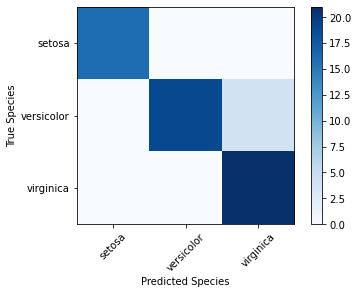

In [13]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np 
# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=45)
plt.yticks(tick_marks, iris.target_names)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")
plt.show()

The confusion matrix should show a strong diagonal line indicating that there are more correct than incorrect predictions for each class.

### Using the Model with New Data
Now that we have a model we believe is reasonably accurate, we can use it to predict the species of new iris observations:

In [15]:
# Save the model weights
model_file = 'iris_classifier.pt'
torch.save(model.state_dict(), model_file)
del model

# New data
x_new = [[6.6,3.2,5.8,2.4]]
print ('New sample: {}'.format(x_new))

# Create a new model class and load weights
model = IrisNet()
model.load_state_dict(torch.load(model_file))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:',iris.target_names[predicted.item()])

New sample: [[6.6, 3.2, 5.8, 2.4]]
Prediction: virginica
